# Inverse design optimization of a compact grating coupler

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

**This notebook contains a long optimization. Running the entire notebook will cost about 20 FlexCredits and take several hours.**

The ability to couple light in and out of photonic integrated circuits (PICs) is crucial for developing wafer-scale systems and tests. This need makes designing efficient and compact grating couplers an important task in the PIC development cycle. In this notebook, we will demonstrate how to use [Tidy3D's adjoint plugin](../notebooks/AdjointPlugin1Intro.html) to perform the inverse design of a compact 3D grating coupler. We will show how to improve design fabricability by enhancing permittivity binarization and controlling the device's minimum feature size.

In addition, if you are interested in more conventional designs, we modeled an [uniform grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/GratingCoupler/) and a [Focusing apodized grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/FocusedApodGC/) in previous case studies.

We start by importing our typical python packages, `jax`, `tidy3d` and its `adjoint` plugin.

In [1]:
# Standard python imports.
from typing import List
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import os
import json
import pydantic as pd
from typing import Callable

# Import jax to be able to use automatic differentiation.
import jax.numpy as jnp
import jax.scipy as jsp
from jax import value_and_grad

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

# Import the components we need from the adjoint plugin.
from tidy3d.plugins.adjoint import (
    JaxSimulation, 
    JaxBox, 
    JaxCustomMedium, 
    JaxStructure,
    JaxSimulationData,
    JaxDataArray,
    JaxPermittivityDataset,
)
from tidy3d.plugins.adjoint.web import run


## Grating Coupler Inverse Design Configuration

The grating coupler inverse design begins with a rectangular design region connected to a $Si$ waveguide. Throughout the optimization process, this initial structure evolves to convert a vertically incident Gaussian-like mode from an optical fiber into a guided mode and then funnel it into the $Si$ waveguide.

We are considering a full-etched grating structure, so a $SiO_{2}$ BOX layer is included. To reduce backreflection, we adjusted the fiber tilt angle to $10^{\circ}$ [[1](https://doi.org/10.1364/OE.23.022628), [2](https://doi.org/10.3390/mi11070666)].

In the following block of code, you can find the parameters that can be modified to configure the grating coupler structure, optimization, and simulation setup. Special care should be devoted to the `it_per_step` and `opt_steps` variables bellow.

In [2]:
# Geometric parameters.
w_thick = 0.22  # Waveguide thickness (um).
w_width = 0.5  # Waveguide width (um).
w_length = 1.0  # Waveguide length (um).
box_thick = 1.6  # SiO2 BOX thickness (um).
spot_size = 2.5  # Spot size of the input Gaussian field regarding a lensed fiber (um).
fiber_tilt = 10.0  # Fiber tilt angle (degrees).
src_offset = 0.05  # Distance between the source focus and device (um).

# Material.
nSi = 3.48  # Silicon refractive index.
nSiO2 = 1.44  # Silica refractive index.

# Design region parameters.
gc_width = 4.0  # Grating coupler width (um).
gc_length = 4.0  # Grating coupler length (um).
dr_grid_size = 0.02  # Grid size within the design region (um).

# Inverse design set up parameters.
#################################################################
# Total number of iterations = opt_steps x it_per_step.
it_per_step = 10  # Number of iterations per optimization step.
opt_steps = 15 # Number of optimization steps.
#################################################################
feature_size = 0.070 # Minimum feature size (um).
eta = 0.50  # Threshold value for the projection filter.
init_beta = 10  # Sharpness parameter for the projection filter.
del_beta = 10  # Increments of beta at each optimization step.
fom_name = "fom_field"  # Name of the monitor used to compute the objective function.

# Simulation wavelength.
wl = 1.55  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

In [3]:
total_iter = opt_steps * it_per_step
print(f"Total iterations = {total_iter}")


Total iterations = 150


## Inverse Design Optimization Set Up

We will calculate the values of some parameters used throughout the inverse design set up.

In [4]:
# Minimum and maximum values for the permittivities.
eps_max = nSi**2
eps_min = 1.0

# Material definitions.
mat_si = td.Medium(permittivity=eps_max)  # Waveguide material.
mat_sio2 = td.Medium(permittivity=nSiO2**2)  # Substrate material.

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-12

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = pml_spacing + w_length + gc_length
size_y = gc_width + 2 * pml_spacing
size_z = w_thick + box_thick + 2 * pml_spacing
center_z = size_z / 2 - pml_spacing - w_thick / 2
eff_inf = 1000

# Inverse design variables.
src_pos_z = w_thick / 2 + src_offset
mon_pos_x = -size_x / 2 + 0.25 * wl
mon_w = int(3 * w_width / dr_grid_size) * dr_grid_size
mon_h = int(5 * w_thick / dr_grid_size) * dr_grid_size
nx = int(gc_length / dr_grid_size)
ny = int(gc_width / dr_grid_size / 2.0)
npar = nx * ny
dr_size_x = nx * dr_grid_size
dr_size_y = 2 * ny * dr_grid_size
dr_center_x = -size_x / 2 + w_length + dr_size_x / 2


First, we will introduce the simulation components that do not change during optimization, such as the $Si$ waveguide and $SiO_{2}$ BOX layer. Additionally, we will include a Gaussian source to drive the simulations, and a mode monitor to compute the objective function.

In [5]:
# Input/output waveguide.
waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -w_width / 2, -w_thick / 2),
        rmax=(-size_x / 2 + w_length, w_width / 2, w_thick / 2),
    ),
    medium=mat_si,
)

# SiO2 BOX layer.
sio2_substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -w_thick / 2 - box_thick), 
        rmax=(eff_inf, eff_inf, -w_thick / 2)
    ),
    medium=mat_sio2,
)

# Si substrate.
si_substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf), 
        rmax=(eff_inf, eff_inf, -w_thick / 2 - box_thick)
    ),
    medium=mat_si,
)

# Gaussian source focused above the grating coupler.
gauss_source = td.GaussianBeam(
    center=(dr_center_x, 0, src_pos_z),
    size=(dr_size_x, dr_size_y, 0),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    pol_angle=np.pi / 2,
    angle_theta=fiber_tilt * np.pi / 180.0,
    direction="-",
    num_freqs=7,
    waist_radius=spot_size / 2,
)

# Monitor where we will compute the objective function from.
mode_spec = td.ModeSpec(num_modes=1, target_neff=nSi)
fom_monitor = td.ModeMonitor(
    center=[mon_pos_x, 0, 0],
    size=[0, mon_w, mon_h],
    freqs=[freq],
    mode_spec=mode_spec,
    name=fom_name,
)


Now, we will define a random vector of initial design parameters or load a previously designed structure.

> Note: if a previous optimization file is found, the optimizer will pick up where that left off instead.

In [6]:
init_par = np.random.uniform(0, 1, npar)
init_par = sp.ndimage.gaussian_filter(init_par, 1)

### Fabrication Constraints

We will use `jax` to build functions that improve device fabricability. A classical conic density filter, which is popular in topology optimization problems, is used to enforce a minimum feature size specified by the `feature_size` variable. Next, a hyperbolic tangent projection function is applied to eliminate grayscale and obtain a binarized permittivity pattern. The `beta` parameter controls the sharpness of the transition in the projection function, and for better results, this parameter should be gradually increased throughout the optimization process. Finally, the design parameters are transformed into permittivity values. For a detailed review of these methods, refer to [[3](https://doi.org/10.1007/s00419-015-1106-4)].

In [7]:
def get_eps(design_param, beta: float = 1.00, binarize: bool = False) -> np.ndarray:
    """Returns the permittivities after applying a conic density filter on design parameters
    to enforce fabrication constraints, followed by a binarization projection function
    which reduces grayscale.
    Parameters:
        design_param: np.ndarray
            Vector of design parameters.
        beta: float = 1.0
            Sharpness parameter for the projection filter.
        binarize: bool = False
            Enforce binarization.
    Returns:
        eps: np.ndarray
            Permittivity vector.
    """
    # Reshapes the design parameters into a 2D matrix.
    rho = np.reshape(design_param, (nx, ny))

    # Builds the conic filter and apply it to design parameters.
    filter_radius = np.ceil((feature_size * np.sqrt(3)) / dr_grid_size)
    xy = np.linspace(-filter_radius, filter_radius, int(2 * filter_radius + 1))
    xm, ym = np.meshgrid(xy, xy)
    xy_rad = np.sqrt(xm**2 + ym**2)
    kernel = jnp.where(filter_radius - xy_rad > 0, filter_radius - xy_rad, 0)
    filt_den = jsp.signal.convolve(jnp.ones_like(rho), kernel, mode="same")
    rho_dot = jsp.signal.convolve(rho, kernel, mode="same") / filt_den

    # Applies a hyperbolic tangent binarization function.
    rho_bar = (jnp.tanh(beta * eta) + jnp.tanh(beta * (rho_dot - eta))) / (
        jnp.tanh(beta * eta) + jnp.tanh(beta * (1.0 - eta))
    )

    # Calculates the permittivities from the transformed design parameters.
    eps = eps_min + (eps_max - eps_min) * rho_bar
    if binarize:
        eps = jnp.where(eps < (eps_min + eps_max) / 2, eps_min, eps_max)
    else:        
        eps = jnp.where(eps < eps_min, eps_min, eps)
        eps = jnp.where(eps > eps_max, eps_max, eps)
    return eps


### Using Tidy3d Convenience wrappers

In Tidy3D 2.4.0, there are wrappers for the above operations which you may use instead for added convenience.

We will implement the above function using such filtering and projection utilities as a demonstration.

In [8]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter, BinaryProjector

def get_eps(design_param, beta: float = 1.00, binarize: bool = False) -> np.ndarray:
    """Returns the permittivities after applying a conic density filter on design parameters
    to enforce fabrication constraints, followed by a binarization projection function
    which reduces grayscale.
    Parameters:
        design_param: np.ndarray
            Vector of design parameters.
        beta: float = 1.0
            Sharpness parameter for the projection filter.
        binarize: bool = False
            Enforce binarization.
    Returns:
        eps: np.ndarray
            Permittivity vector.
    """
    filter_radius = np.sqrt(3) * feature_size
    conic_filter = ConicFilter(radius=filter_radius, design_region_dl=dr_grid_size)
    binary_projector = BinaryProjector(vmin=eps_min, vmax=eps_max, eta=eta, beta=beta, strict_binarize=binarize)
    
    rho_dot = conic_filter.evaluate(design_param.reshape(nx, ny))
    return binary_projector.evaluate(rho_dot)
    

The permittivity values obtained from the design parameters are then used to build a [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html). As we will consider symmetry about the x-axis in the simulations, only the upper-half part of the design region needs to be populated. A `JaxStructure` built using the `JaxCustomMedium` will be returned by the following function: 

In [9]:
def update_design(eps, unfold: bool = False) -> List[JaxStructure]:
    # Reflects the structure about the x-axis.
    nyii = ny
    y_min = 0
    dr_s_y = dr_size_y / 2
    dr_c_y = dr_s_y / 2
    eps_val = jnp.array(eps).reshape((nx, ny, 1, 1))
    if unfold:
        nyii = 2 * ny
        y_min = -dr_size_y / 2
        dr_s_y = dr_size_y
        dr_c_y = 0
        eps_val = np.concatenate((np.fliplr(np.copy(eps_val)), eps_val), axis=1)

    # Definition of the coordinates x,y along the design region.
    coords_x = [(dr_center_x - dr_size_x / 2) + ix * dr_grid_size for ix in range(nx)]
    coords_y = [y_min + iy * dr_grid_size for iy in range(nyii)]
    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq])

    # Creation of a custom medium using the values of the design parameters.
    eps_components = {
        f"eps_{dim}{dim}": JaxDataArray(values=eps_val, coords=coords) for dim in "xyz"
    }
    eps_dataset = JaxPermittivityDataset(**eps_components)
    eps_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = JaxBox(center=(dr_center_x, dr_c_y, 0), size=(dr_size_x, dr_s_y, w_thick))
    design_structure = JaxStructure(geometry=box, medium=eps_medium)
    return [design_structure]


Next, we will write a function to return the `JaxSimulation` object. Note that we are using a `MeshOverrideStructure` to obtain a uniform mesh over the design region.

In [10]:
def make_adjoint_sim(
    design_param, beta: float = 1.00, unfold: bool = False, binarize: bool=False
) -> JaxSimulation:
    # Builds the design region from the design parameters.
    eps = get_eps(design_param, beta, binarize)
    design_structure = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick)
        ),
        dl=[dr_grid_size, dr_grid_size, dr_grid_size],
        enforce=True,
    )

    return JaxSimulation(
        size=[size_x, size_y, size_z],
        center=[0, 0, -center_z],
        grid_spec=td.GridSpec.auto(
            wavelength=wl_max,
            min_steps_per_wvl=15,
            override_structures=[adjoint_dr_mesh],
        ),
        symmetry=(0, -1, 0),
        structures=[waveguide, sio2_substrate, si_substrate],
        input_structures=design_structure,
        sources=[gauss_source],
        monitors=[],
        output_monitors=[fom_monitor],
        run_time=run_time,
        subpixel=True,
    )


Let's visualize the simulation set up and verify if all the elements are in their correct places.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


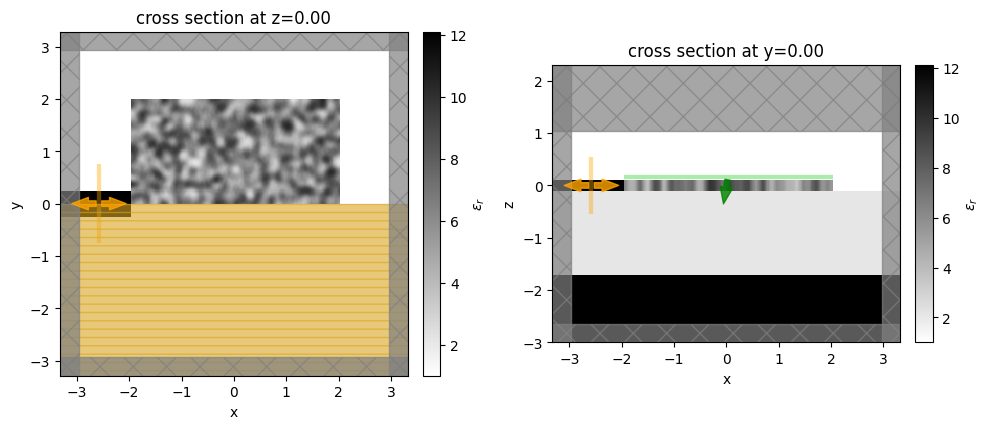

In [11]:
init_design = make_adjoint_sim(init_par, beta=init_beta)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 10))
init_design.plot_eps(z=0, ax=ax1)
init_design.plot_eps(y=0, ax=ax2)
plt.show()


## Optimization

We need to provide an objective function and its gradients with respect to the design parameters of the optimization algorithm.

Our figure-of-merit (FOM) is the coupling efficiency of the incident power into the fundamental transverse electric mode of the $Si$ waveguide. The optimization algorithm will call the objective function at each iteration step. Therefore, the objective function will create the adjoint simulation, run it, and return the FOM value.

In [12]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: JaxSimulationData) -> float:
    """Return the power at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="-", f=freq, mode_index=0)
    return jnp.sum(jnp.abs(amp) ** 2)

# Objective function to be passed to the optimization algorithm.
def obj(
    design_param, beta: float = 1.0, step_num: int = None, verbose: bool = False
) -> float:
    sim = make_adjoint_sim(design_param, beta)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name, verbose=verbose)
    fom_val = fom(sim_data)
    return fom_val

# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad = value_and_grad(obj)


Next we will define the optimizer using `optax`. We will save the optimization progress in a `pickle` file. If that file is found, it will pick up the optimization from the last state. Otherwise, we will create a blank history.

In [13]:
import optax
import pickle

# hyperparameters
learning_rate = 0.02
optimizer = optax.adam(learning_rate=learning_rate)

# where to store history
history_fname = "misc/grating_coupler_history.pkl"

def save_history(history_dict: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, 'wb') as file:
        pickle.dump(history_dict, file)

def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, 'rb') as file:
        history_dict = pickle.load(file)
    return history_dict

### Checking For a Previous Optimization

If `history_fname` is a valid file, the results of a previous optimization are loaded, then the optimization will continue from the last iteration step. If the optimization was completed, only the final structure will be simulated. The pickle file used in this notebook can be downloaded from our documentation [repo](https://github.com/flexcompute-readthedocs/tidy3d-docs/tree/readthedocs/docs/source/notebooks/misc).

In [14]:
try:
    history_dict = load_history()
    opt_state = history_dict["opt_states"][-1]
    params = history_dict["params"][-1]
    num_iters_completed = len(history_dict["params"])
    print("Loaded optimization checkpoint from file.")
    print(f"Found {num_iters_completed} iterations previously completed out of {total_iter} total.")
    if num_iters_completed < total_iter:
        print(f"Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except FileNotFoundError:
    
    params = np.array(init_par)
    opt_state = optimizer.init(params)
    history_dict = dict(
        values=[],
        params=[],
        gradients=[],
        opt_states=[opt_state],
    )

Loaded optimization checkpoint from file.
Found 150 iterations previously completed out of 150 total.
Optimization completed, will return results.


In [15]:
iter_done = len(history_dict['values'])

for i in range(iter_done, total_iter):
    print(f"iteration = {i + 1}")

    # compute gradient and current objective funciton value
    step = i // it_per_step
    beta_i = init_beta + step * del_beta
    value, gradient = obj_grad(params, beta=beta_i)

    # outputs
    print(f"\tstep {step}, beta = {beta_i}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    history_dict["values"].append(value)
    history_dict["params"].append(params)
    history_dict["gradients"].append(gradient)
    history_dict["opt_states"].append(opt_state)
    save_history(history_dict)


### Optimization Results

After 150 iterations, a coupling efficiency value of 0.71 (-1.48 dB) was achieved at the central wavelength.

In [16]:
obj_vals = np.array(history_dict["values"])
final_par = history_dict["params"][-1]
final_beta = init_beta + total_iter // it_per_step * del_beta

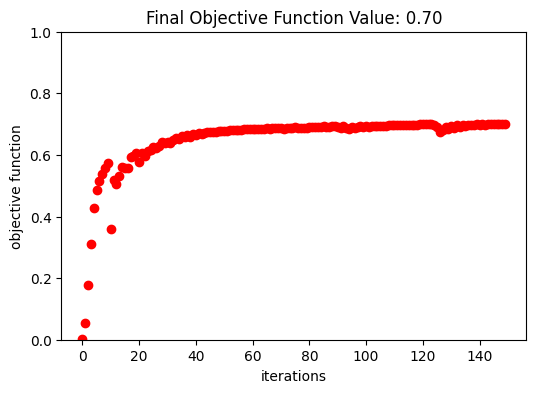

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_ylim(0, 1)
ax.set_title(f"Final Objective Function Value: {obj_vals[-1]:.2f}")
plt.show()


The final grating coupler structure is well binarized, with mostly black (`eps_max`) and white (`eps_min`) regions.

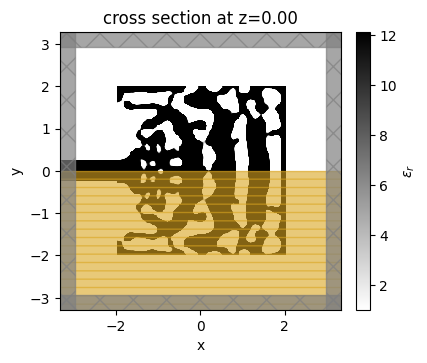

In [18]:
fig, ax = plt.subplots(1, figsize=(4, 4))
sim_final = make_adjoint_sim(final_par, beta=final_beta, unfold=True)
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax)
plt.show()


Once the inverse design is complete, we can visualize the field distributions and the wavelength dependent coupling efficiency.

In [19]:
# Field monitors to visualize the final fields.
field_xy = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="field_xy",
)

field_xz = td.FieldMonitor(
    size=(td.inf, 0, td.inf),
    freqs=[freq],
    name="field_xz",
)

# Monitor to compute the grating coupler efficiency.
gc_efficiency = td.ModeMonitor(
    center=[mon_pos_x, 0, 0],
    size=[0, mon_w, mon_h],
    freqs=freqs,
    mode_spec=mode_spec,
    name="gc_efficiency",
)

sim_final = sim_final.copy(update=dict(monitors=(field_xy, field_xz, gc_efficiency)))
sim_data_final = web.run(sim_final, task_name="inv_des_final")

[20:35:07] WARNING: Default value for the field monitor           ]8;id=772198;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=595187;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=600476;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=530986;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           Created task 'inv_des_final' with task_id               ]8;id=352776;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=212606;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-953daca3-149a-4d0c-8223-4108801549a7v1'.                       

           View task using web UI at                               ]8;id=820662;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=995076;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=222976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-953daca3-149a-4d0c-8223-4108801549a7v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=585157;https://tidy3d.simulation.cloud/workbench?taskId=fdve-953daca3-149a-4d0c-8223-4108801549a7v1\taskId]8;;\]8;id=222976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-953daca3-149a-4d0c-8223-4108801549a7v1\=]8;;\]8;id=619351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-953daca3-149a-4d0c-8223-4108801549a7v1\fdve]8;;\]8;id=222976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-953daca3-149a-4d0c-8223-4108801549a7v1\-]8;;\              
           ]8;id=222976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-953daca3-149a-4d0c-8223-4108801549a7v1\953daca3-149a-4d0c-8223-4108801549a7v1']8;;\.                             

Output()

[20:35:13] status = queued                                         ]8;id=52539;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=54379;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[20:35:28] status = preprocess                                     ]8;id=358166;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=141930;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[20:35:38] Maximum FlexCredit cost: 0.183. Use                     ]8;id=503378;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=494471;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=590961;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=590696;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=522213;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=842941;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=692928;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=675998;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[20:36:05] early shutoff detected, exiting.                        ]8;id=462641;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=208377;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=715511;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434284;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[20:36:20] status = success                                        ]8;id=883485;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=478445;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[20:36:22] loading SimulationData from simulation_data.hdf5        ]8;id=496834;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=150213;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

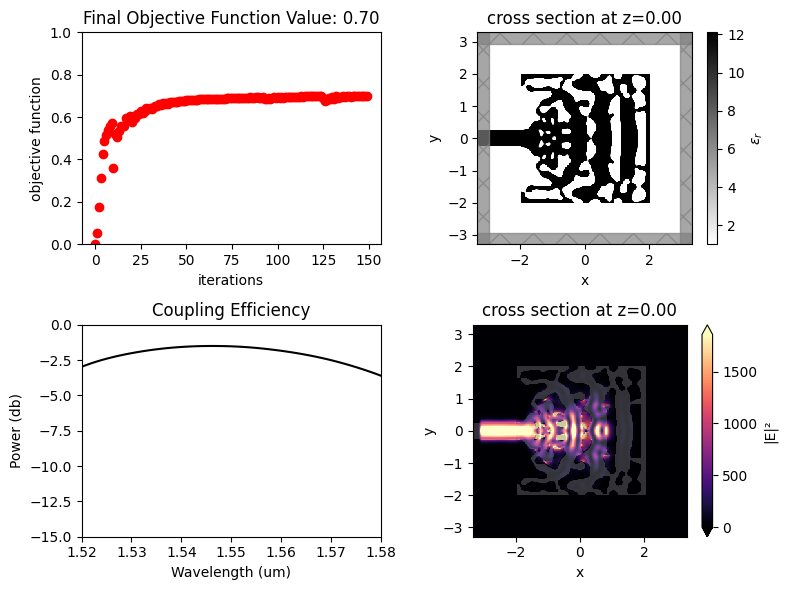

In [20]:
mode_amps = sim_data_final["gc_efficiency"]
coeffs_f = mode_amps.amps.sel(direction="-")
power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_0_db = 10 * np.log10(power_0)

sim_plot = sim_final.updated_copy(symmetry=(0, 0, 0), monitors=(field_xy, field_xz, gc_efficiency))
sim_data_plot = sim_data_final.updated_copy(simulation=sim_plot)

f, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
sim_plot.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax[0, 1])
ax[1, 0].plot(wl_range, power_0_db, "-k")
ax[1, 0].set_xlabel("Wavelength (um)")
ax[1, 0].set_ylabel("Power (db)")
ax[1, 0].set_ylim(-15, 0)
ax[1, 0].set_xlim(wl - bw / 2, wl + bw / 2)
ax[1, 0].set_title("Coupling Efficiency")
sim_data_plot.plot_field("field_xy", "E", "abs^2", z=0, ax=ax[1, 1])
ax[0, 0].plot(obj_vals, "ro")
ax[0, 0].set_xlabel("iterations")
ax[0, 0].set_ylabel("objective function")
ax[0, 0].set_ylim(0, 1)
ax[0, 0].set_title(f"Final Objective Function Value: {obj_vals[-1]:.2f}")
plt.show()